# Download library

In [4]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.7 MB/s eta 0:00:00


In [5]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.3 MB/s eta 0:00:00


In [6]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-kzmddtd5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-kzmddtd5
  Resolved https://github.com/huggingface/accelerate to commit 420743af22c34a72b19970a97ae829e31285c49e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.24.0.dev0-py3-none-any.whl size=258253 sha256=7e2f2920b13e5add46085bb942efa65cbf9dfdf455d75f9d14337822e0a88512
  Stored in directory: /tmp/pip-ephem-wheel-cache-je_gc2kc/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.23.0
    Uninstalling accelerate-0.23.0:
      Successfully uninstalled accelerate-0.23.0


In [7]:
# !pip install huggingface_hub

# Load data and pre-processing

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [10]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import random
from sklearn.utils import shuffle

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [20]:
train_p = pd.read_csv("/content/drive/MyDrive/data/train_p.csv")
test_p = pd.read_csv('/content/drive/MyDrive/data/test_p.csv')

train_r = pd.read_csv("/content/drive/MyDrive/data/train_r.csv")
test_r = pd.read_csv('/content/drive/MyDrive/data/test_r.csv')

valid_p = pd.read_csv("/content/drive/MyDrive/data/valid_p.csv")
valid_r = pd.read_csv('/content/drive/MyDrive/data/valid_r.csv')


In [21]:
# R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']
# Return a list of indices
intro_idx=random.sample(list(train_r.query('label=="introduction"').index), 5)
cl_idx=random.sample(list(train_r.query('label=="clarification"').index),5)
work_idx=random.sample(list(train_r.query('label=="workshop management"').index),5)
imp_idx=random.sample(list(train_r.query('label=="implementation"').index),5)
fail_idx=random.sample(list(train_r.query('label=="failure"').index),5)

# Use indices to select data
train_r = train_r.loc[intro_idx + cl_idx + work_idx+ imp_idx + fail_idx]

# Return a list of indices
info_idx=random.sample(list(train_p.query('label=="information"').index),5)
des_idx=random.sample(list(train_p.query('label=="design action"').index),5)
fa1_idx=random.sample(list(train_p.query('label=="failure action"').index),5)
fa2_idx=random.sample(list(train_p.query('label=="failure reasoning"').index),5)
per_idx=random.sample(list(train_p.query('label=="perception"').index),5)

# Use indices to select data
train_p = train_p.loc[info_idx + des_idx + fa1_idx+ fa2_idx + per_idx]

In [13]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']


#Config

In [22]:
# params
bert_lr = 2e-5
max_length=256
epoch = 20
patience = 2
factor = 0.5
# loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss().to(device)
#batch size
batch_size = 16
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
n_train_r=len(train_r)
n_valid_r=len(valid_r)

n_train_p=len(train_p)
n_valid_p=len(valid_p)


# Model

In [23]:
class TextDataset(Dataset):

    def __init__(self, text, targets, tokenizer):

        self.targets = targets
        self.text = list(text)
        self.tokenizer = tokenizer
        self.encoded_captions = tokenizer(self.text, padding=True, truncation=True, max_length=max_length)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        item = {
            key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()
        }

        item['target'] = self.targets[index]

        return item


def create_text_loader(df, shuffle=True):
    ds = TextDataset(text=df['text'].values,
                     targets=df['index'].values,
                     tokenizer=tokenizer)

    return DataLoader(ds,
                      batch_size=batch_size
                      ,shuffle=shuffle)



In [24]:
class Bert(nn.Module):

  def __init__(self, n_classes):
    super(Bert, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.out(pooled_output)
    return output

In [25]:
import torch
torch.cuda.empty_cache()

In [26]:
def train_epoch(model, train_dataloader, optimizer, scheduler, n_train):
    model = model.train()
    losses = []
    correct_predictions = 0
    process_bar = tqdm(train_dataloader)
    for d in process_bar:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d['target'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
        process_bar.set_postfix(train_loss=loss.item())

    return correct_predictions.double() / n_train, np.mean(losses)

def eval_model(model, val_dataloader, n_valid):
    model = model.eval()

    losses = []
    correct_predictions = 0
    process_bar = tqdm(val_dataloader)
    for d in process_bar:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        process_bar.set_postfix(val_loss=loss.item())

    return correct_predictions.double() / n_valid, np.mean(losses)


def get_predictions(model, test_data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    for d in test_data_loader:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        probs = F.softmax(outputs, dim=1)

        predictions.extend(preds)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

In [27]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

# Researcher

In [28]:
train_dataloader = create_text_loader(train_r, shuffle=True)
val_dataloader = create_text_loader(valid_r, shuffle=False)
test_dataloader = create_text_loader(test_r, shuffle=False)

In [29]:
model=Bert(5).to(device)
optimizer = AdamW(model.parameters(), lr=bert_lr,correct_bias=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, factor=factor)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [30]:
for e in range(epoch):

  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_dataloader,
                                      optimizer,
                                      scheduler,
                                      n_train_r)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  with torch.no_grad():
      val_acc, val_loss = eval_model(model, val_dataloader, n_valid_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/R_10shot_model.pt')

Epoch 1/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.7012292742729187 accuracy 0.2


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6720184882481892 accuracy 0.08771929824561403

Epoch 2/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.549252212047577 accuracy 0.24


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5807382424672445 accuracy 0.24561403508771928

Epoch 3/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.3957128524780273 accuracy 0.6


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.576397172609965 accuracy 0.23684210526315788

Epoch 4/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.1595163345336914 accuracy 0.92


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5854313453038533 accuracy 0.293859649122807

Epoch 5/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.9537656307220459 accuracy 0.92


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.626176937421163 accuracy 0.24122807017543857

Epoch 6/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.7677609622478485 accuracy 0.96


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6161335309346516 accuracy 0.33771929824561403

Epoch 7/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.6110701858997345 accuracy 0.92


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.5619365056355794 accuracy 0.3640350877192982

Epoch 8/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.48425933718681335 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6140664180119833 accuracy 0.3114035087719298

Epoch 9/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.39146198332309723 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.7583480517069499 accuracy 0.24561403508771928

Epoch 10/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.3239518105983734 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.795618232091268 accuracy 0.2763157894736842

Epoch 11/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.2763928472995758 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.730971137682597 accuracy 0.3201754385964912

Epoch 12/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.2117438018321991 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.668738842010498 accuracy 0.3421052631578947

Epoch 13/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.19871200621128082 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6545449018478393 accuracy 0.3640350877192982

Epoch 14/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.16483938694000244 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.66704150835673 accuracy 0.35964912280701755

Epoch 15/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.14793109893798828 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.6972292025883993 accuracy 0.35964912280701755

Epoch 16/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.15360815078020096 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.7337054808934529 accuracy 0.3464912280701754

Epoch 17/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.1289418488740921 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.7524195830027263 accuracy 0.3289473684210526

Epoch 18/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.12396807968616486 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.770843505859375 accuracy 0.3201754385964912

Epoch 19/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.12229108810424805 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.776264746983846 accuracy 0.3201754385964912

Epoch 20/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.1150248534977436 accuracy 1.0


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.772302516301473 accuracy 0.32456140350877194



In [31]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader)

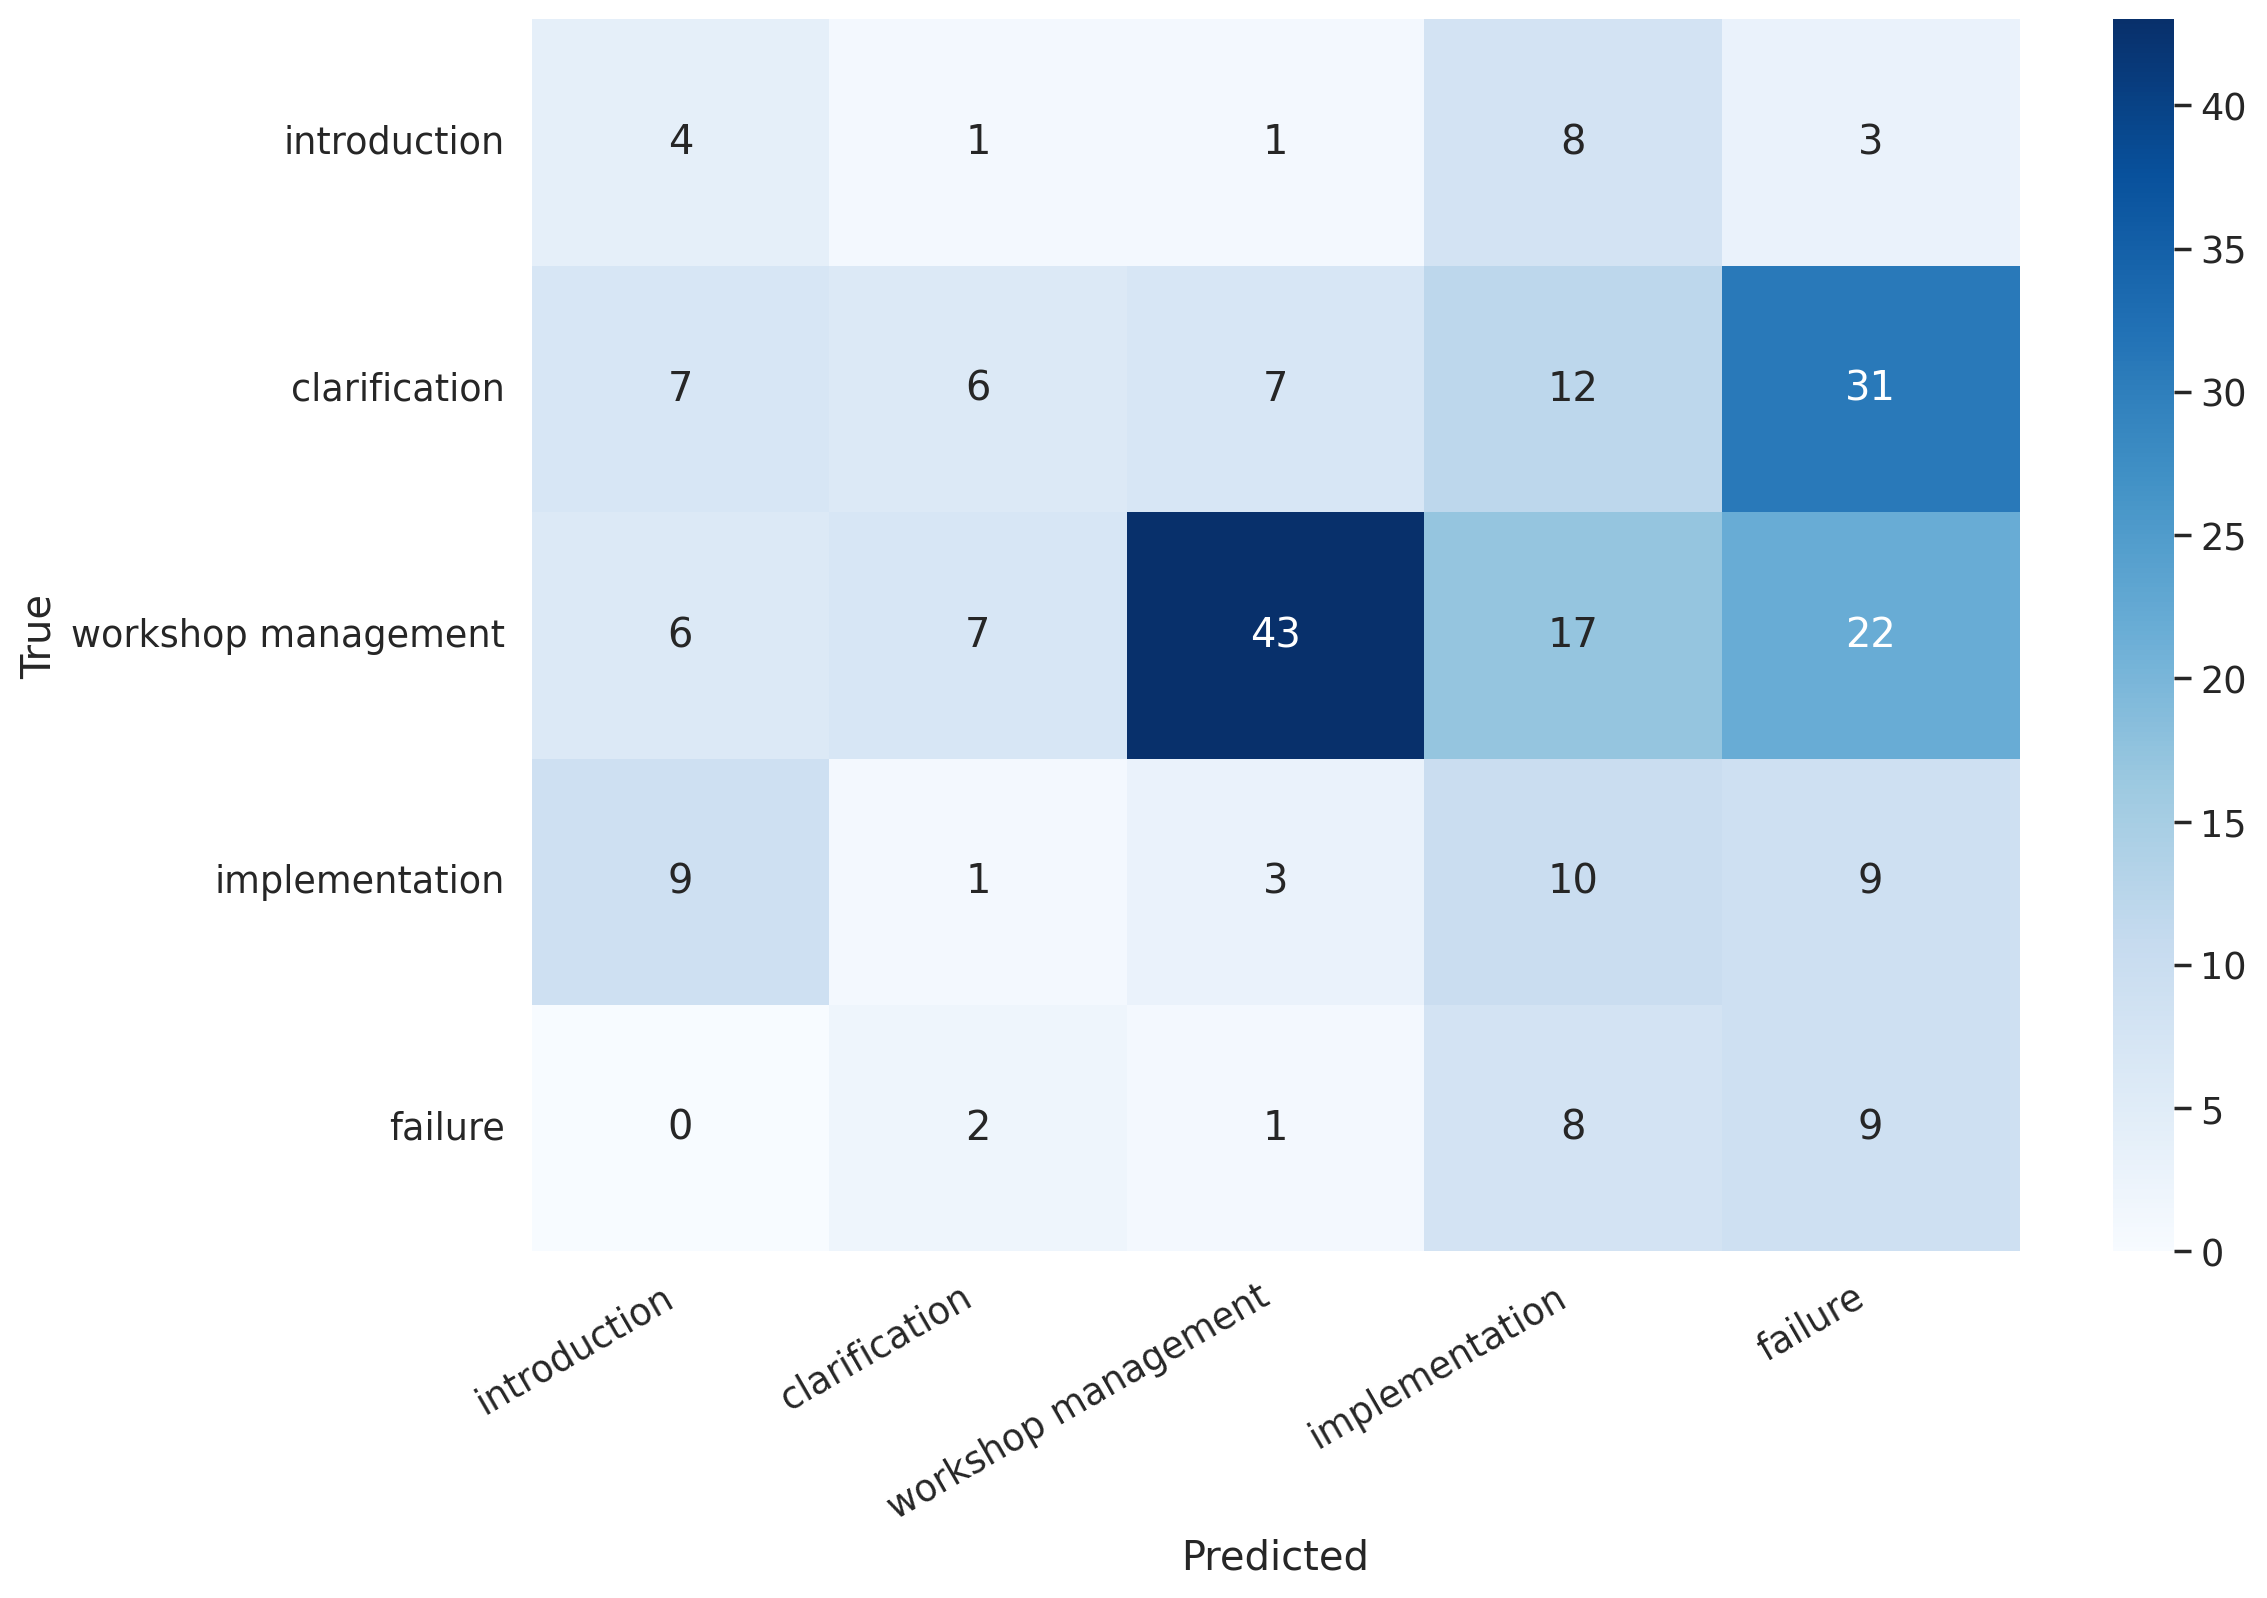

In [32]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [33]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.15      0.24      0.19        17
      clarification       0.35      0.10      0.15        63
workshop management       0.78      0.45      0.57        95
     implementation       0.18      0.31      0.23        32
            failure       0.12      0.45      0.19        20

           accuracy                           0.32       227
          macro avg       0.32      0.31      0.27       227
       weighted avg       0.47      0.32      0.34       227



# Participant

In [34]:
train_dataloader_p = create_text_loader(train_p, shuffle=True)
val_dataloader_p = create_text_loader(valid_p, shuffle=False)
test_dataloader_p = create_text_loader(test_p, shuffle=False)

In [35]:
model=Bert(5).to(device)
optimizer = AdamW(model.parameters(), lr=bert_lr,correct_bias=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, factor=factor)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [36]:
for e in range(epoch):

  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_dataloader_p,
                                      optimizer,
                                      scheduler,
                                      n_train_p)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  with torch.no_grad():
      val_acc, val_loss = eval_model(model, val_dataloader_p, n_valid_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/P_10shot_model.pt')

Epoch 1/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.6426758170127869 accuracy 0.12


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.6161897381146748 accuracy 0.2142857142857143

Epoch 2/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.554916262626648 accuracy 0.28


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.6278785665829976 accuracy 0.18131868131868134

Epoch 3/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.3758262991905212 accuracy 0.76


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5885707835356395 accuracy 0.23076923076923078

Epoch 4/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.1554064750671387 accuracy 0.76


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.640156666437785 accuracy 0.23076923076923078

Epoch 5/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.9450676441192627 accuracy 0.92


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.7571789622306824 accuracy 0.20329670329670332

Epoch 6/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.7607336342334747 accuracy 0.96


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.7758097648620605 accuracy 0.24725274725274726

Epoch 7/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.6058428883552551 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.7080485324064891 accuracy 0.2197802197802198

Epoch 8/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.45947499573230743 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.726468950510025 accuracy 0.23076923076923078

Epoch 9/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.41491924226284027 accuracy 0.96


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8200545410315196 accuracy 0.2087912087912088

Epoch 10/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.2946917712688446 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8446354071299236 accuracy 0.22527472527472528

Epoch 11/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.24278997629880905 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8258137106895447 accuracy 0.24725274725274726

Epoch 12/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.1964520812034607 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8285999298095703 accuracy 0.25824175824175827

Epoch 13/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.16053100675344467 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8485500514507294 accuracy 0.2527472527472528

Epoch 14/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.1592392921447754 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8749796350797017 accuracy 0.2417582417582418

Epoch 15/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.14162477105855942 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.8958486318588257 accuracy 0.25824175824175827

Epoch 16/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.12836068123579025 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.9038068453470867 accuracy 0.2527472527472528

Epoch 17/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.1239154264330864 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.9094791014989216 accuracy 0.2527472527472528

Epoch 18/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.11353103443980217 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.9144725104173024 accuracy 0.2527472527472528

Epoch 19/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.10330745950341225 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.9154286086559296 accuracy 0.2527472527472528

Epoch 20/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.09729494154453278 accuracy 1.0


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.9163829386234283 accuracy 0.2527472527472528



In [37]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader_p)

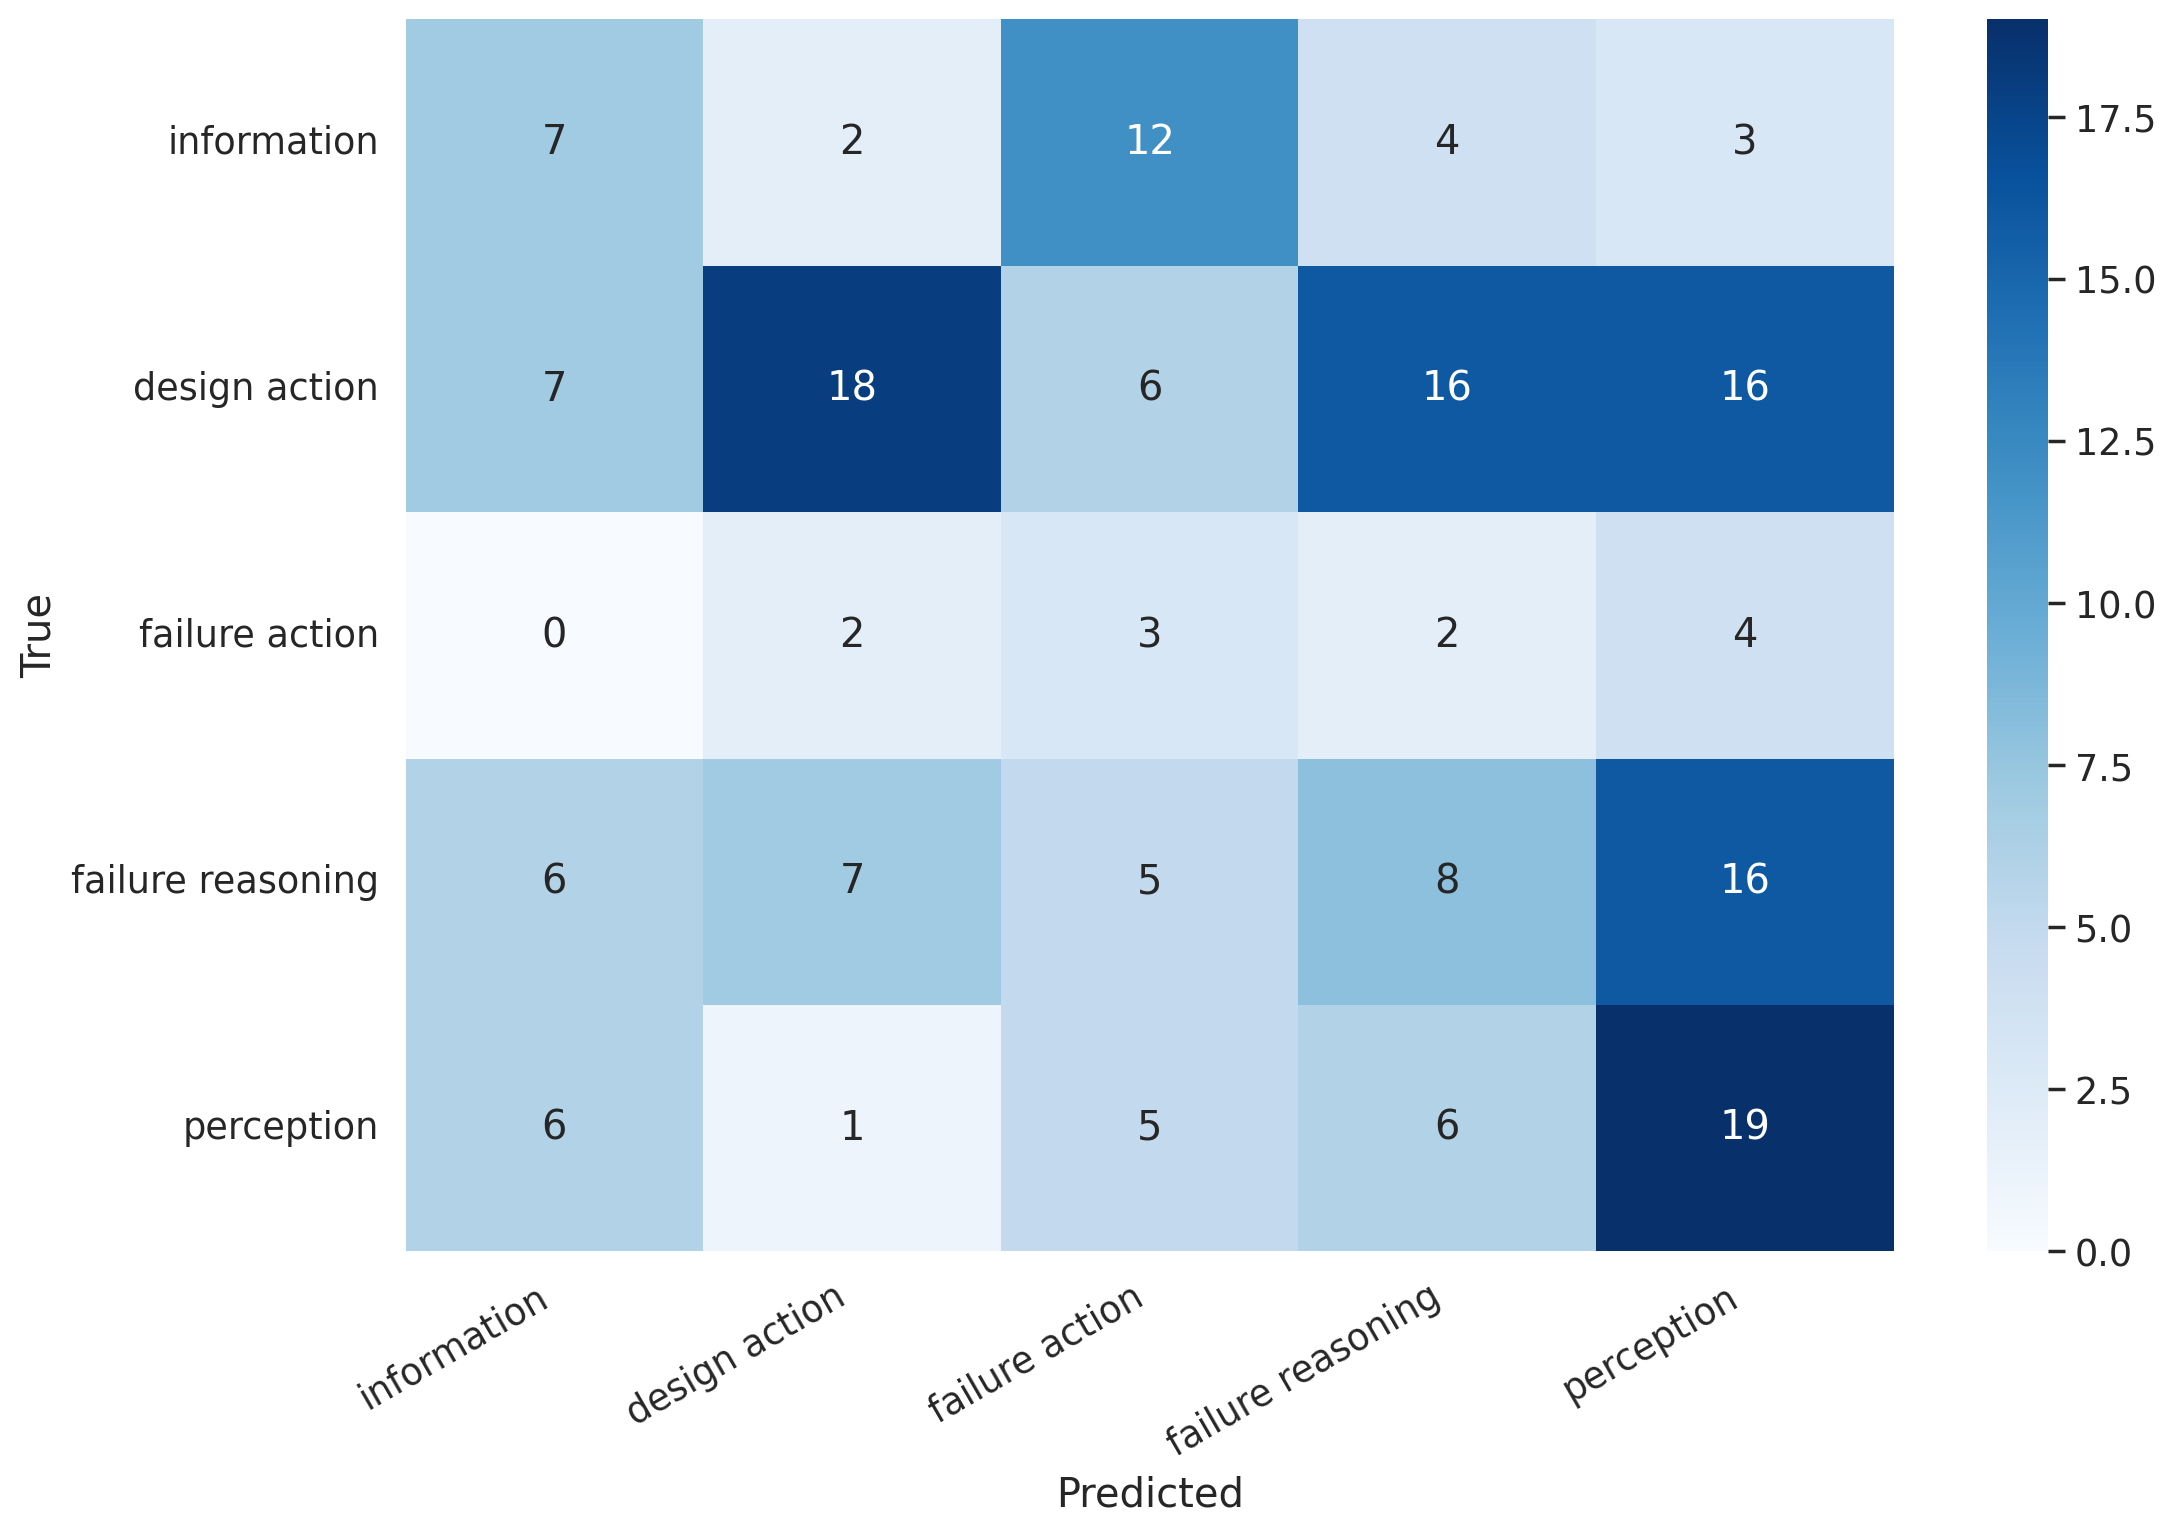

In [39]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [40]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.27      0.25      0.26        28
    design action       0.60      0.29      0.39        63
   failure action       0.10      0.27      0.14        11
failure reasoning       0.22      0.19      0.21        42
       perception       0.33      0.51      0.40        37

         accuracy                           0.30       181
        macro avg       0.30      0.30      0.28       181
     weighted avg       0.37      0.30      0.31       181

